In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
%pip install ultralytics
#%pip install glasses-detector
%pip install pyfacer
%pip install timm
%pip install scikit-learn
%pip install Pillow
%pip install torchvision

from matplotlib import pyplot as plt
#import glasses_detector
import os
import time
from PIL import Image
import matplotlib.image as mpimg
from ultralytics import YOLO
import numpy as np
from sklearn.cluster import KMeans
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import pairwise_distances_argmin_min
from sklearn.model_selection import train_test_split
from sklearn.semi_supervised import LabelPropagation
import torch
from torchvision.transforms.functional import to_pil_image
import facer
import shutil
import csv
import copy
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import plotly.graph_objects as go
import plotly.express as px
from io import BytesIO
import base64


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.6/780.6 kB 2.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [4]:
# Directory principale del tuo progetto Waltico
project_dir = '/content/gdrive/My Drive/Progetto Computer Vision/'

In [ ]:
# Directory principale del tuo progetto Giansimone
project_dir = '/content/gdrive/MyDrive/Colab Notebooks/Computer Vision e Deep Learning/Progetto Computer Vision'

### Detection


In [5]:
class FaceDetection:
    def __init__(self, project_dir):
        self._project_dir = project_dir
        self._model_path = os.path.join(self._project_dir, 'data/models/yolov8l-face.pt')
        assert os.path.exists(self._model_path), "Il percorso del modello non è valido"
        self._model = YOLO(self._model_path)
        print("Inizializzazione...")

    def face_detection(self, input_dir='data/images', output_dir='results/faces'):
        # Prepara le directory di input e output
        input_dir = self._prepare_directory(input_dir)
        output_dir = self._prepare_directory(output_dir, create=True)

        # Processa ciascuna immagine nella directory di input
        image_files = os.listdir(input_dir)
        for i, image_file in enumerate(image_files):
            image_path = os.path.join(input_dir, image_file)
            results = self._model(image_path)
            self._process_results(results, image_path, output_dir, i, len(image_files))

        print("Processo concluso con successo")

    def _prepare_directory(self, dir_path, create=False):
        # Costruisce il percorso completo della directory
        full_path = os.path.join(self._project_dir, dir_path)
        if create and not os.path.exists(full_path):
            os.makedirs(full_path)
            print(f"Directory creata: {full_path}")
        return full_path

    def _process_results(self, results, image_path, output_dir, image_index, total_images):
        # Ritaglia e salva le immagini di ciascuna bounding box rilevata
        img = Image.open(image_path)
        for result in results:
            boxes = result.boxes.data
            for box_index, box in enumerate(boxes):
                cropped_img = self._crop_image(img, box)
                output_file = self._generate_output_filename(output_dir, image_index, total_images, box_index, len(boxes))
                cropped_img.save(output_file)

    def _crop_image(self, img, box):
        # Ritaglia l'immagine utilizzando le coordinate della bounding box
        x_min, y_min, x_max, y_max = box.tolist()[:4]
        return img.crop((x_min, y_min, x_max, y_max))

    def _generate_output_filename(self, output_dir, image_index, total_images, box_index, total_boxes):
        # Genera un nome di file per l'immagine ritagliata
        image_index_str = str(image_index).zfill(len(str(total_images)))
        box_index_str = str(box_index).zfill(len(str(total_boxes)))
        return os.path.join(output_dir, f'result_{image_index_str}_{box_index_str}.jpg')


## Face Segmenetation

In [6]:
class FaceSegmentation:
    def __init__(self, project_dir):
        # Imposta directory di progetto e dispositivo
        self._project_dir = project_dir
        self._device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Inizializza i rilevatori e parser facciali
        self._face_detector = facer.face_detector('retinaface/mobilenet', device=self._device)
        self._face_parser = facer.face_parser('farl/lapa/448', device=self._device)

    def process_images(self):
        all_segments = {}
        # Processa ciascuna immagine nella directory dei risultati
        for filename in os.listdir(os.path.join(self._project_dir, 'results/faces')):
            image_path = os.path.join(self._project_dir, 'results/faces', filename)
            image = self._load_image(image_path)

            faces = self._detect_faces(image)
            self._visualize_faces(image, faces)

            faces = self._parse_faces(image, faces)
            seg_probs = faces['seg']['logits'].softmax(dim=1)

            all_segments[filename] = self._segment_faces(image, seg_probs, faces)

            self._save_visualization(image, seg_probs, filename)

        return all_segments

    def _load_image(self, image_path):
        # Carica e converte l'immagine nel formato richiesto
        image = facer.hwc2bchw(facer.read_hwc(image_path)).to(device=self._device)
        return image

    def _detect_faces(self, image):
        # Rileva volti nell'immagine
        with torch.inference_mode():
            faces = self._face_detector(image)
        return faces

    def _parse_faces(self, image, faces):
        # Analizza i volti rilevati
        with torch.inference_mode():
            faces = self._face_parser(image, faces)
        return faces

    def _segment_faces(self, image, seg_probs, faces):
        # Segmenta i volti e i relativi componenti
        n_classes = seg_probs.size(1)
        segments = {}
        # Elenco delle classi da escludere
        exclude_classes = ['background', 'mouth']

        for face_id in range(seg_probs.size(0)):
            for class_id in range(n_classes):
                # Ottieni il nome della classe corrente
                class_name = faces['seg']['label_names'][class_id]
                # Salta la classe se è nell'elenco delle classi da escludere
                if class_name in exclude_classes:
                    continue

                mask = (seg_probs[face_id, class_id] > 0.5).float()
                if mask.sum() > 0:
                    if face_id not in segments:
                        segments[face_id] = []
                    segments[face_id].append([mask, class_name])

        return segments

    def _save_visualization(self, image, seg_probs, filename):
        # Salva la visualizzazione delle segmentazioni
        vis_seg_probs = seg_probs.argmax(dim=1).float() / seg_probs.size(1) * 255
        vis_img = vis_seg_probs.sum(0, keepdim=True)
        vis_img_pil = to_pil_image(vis_img.byte())
        directory = os.path.join(self._project_dir, "results/faces_facer")
        if not os.path.exists(directory):
            os.makedirs(directory)
        vis_img_pil.save(os.path.join(directory, f'result_{filename.split("_")[1]}_{filename.split("_")[2]}'), format='JPEG')

    def _visualize_faces(self, image, faces):
        # Mostra i volti rilevati
        facer.show_bchw(facer.draw_bchw(image, faces))


## Glasses Segmentation

In [ ]:
class GlassesSegmentation:
    def __init__(self, project_dir):
        # Imposta directory di progetto e dispositivo
        self._project_dir = project_dir
        self._glasses_detector = glasses_detector.AnyglassesClassifier()

    def process_images(self):
        all_segments = {}
        # Processa ciascuna immagine nella directory dei risultati
        for filename in os.listdir(os.path.join(self._project_dir, 'data/images')):
            image_path = os.path.join(self._project_dir, 'data/images', filename)
            print(filename)
            image = self._load_image(image_path)
            print(image)

    def _load_image(self, image_path, csv_filename = 'glasses_per_image.csv'):
       # Verifica se la directory per il CSV esiste, altrimenti creala
        csv_dir = os.path.join(self._project_dir, 'results/csv')
        if not os.path.exists(csv_dir):
            os.makedirs(csv_dir)

        csv_path = os.path.join(csv_dir, csv_filename)

        sus = self._glasses_detector (image_path)
        return sus


## Color Extraction

In [21]:
class ColorExtractor:
    def __init__(self, project_dir):
        # Imposta directory di progetto e dispositivo
        self._project_dir = project_dir
        self._device = 'cuda' if torch.cuda.is_available() else 'cpu'

    def extract_dominant_colors(self, all_segments, normalize = True):
        dominant_colors = {}
        # Estrae i colori dominanti per ciascun segmento
        for filename, segments in all_segments.items():
            image_tensor = self._load_image(os.path.join(self._project_dir, 'results/faces', filename))
            for face_id, segment_list in segments.items():
                for mask, label_name in segment_list:
                    colors = self._get_segmented_colors(image_tensor, mask)
                    dominant_colors = self._update_dominant_colors(dominant_colors, filename, face_id, label_name, colors)

        return dominant_colors

    def _load_image(self, image_path):
        # Carica e converte l'immagine nel formato richiesto
        image = facer.hwc2bchw(facer.read_hwc(image_path)).to(device=self._device)
        return image

    def _get_segmented_colors(self, image_tensor, mask):
        # Estrae i colori dai segmenti
        pixel_coords = torch.nonzero(mask)
        segmented_colors = [image_tensor[0, :, coord[0], coord[1]].cpu().numpy() for coord in pixel_coords]  # if not self._is_pixel_in_glasses_box(coord, glasses_boxes)]
        return np.array(segmented_colors) if segmented_colors else np.array([])


    def _update_dominant_colors(self, dominant_colors, filename, face_id, label_name, segmented_colors):
      # Elenco delle classi da escludere
      exclude_classes = ['background', 'imouth']
      # Salta la classe se è nell'elenco delle classi da escludere
      if label_name in exclude_classes:
          return dominant_colors

      if segmented_colors.size > 0:
          # Applica KMeans
          kmeans = KMeans(n_clusters=3).fit(segmented_colors)
          # Ottieni i centroidi
          centroids = kmeans.cluster_centers_

          # Trova il colore più vicino a ciascun centroide
          closest_colors = []
          for centroid in centroids:
              distances = np.linalg.norm(segmented_colors - centroid, axis=1)
              closest_color = segmented_colors[np.argmin(distances)]
              closest_colors.append(closest_color)

          if filename not in dominant_colors:
              dominant_colors[filename] = {}
          dominant_colors[filename][label_name] = np.array(closest_colors)

      return dominant_colors


    '''def _is_pixel_in_glasses_box(self, coord, glasses_boxes):
        # Verifica se un pixel è dentro una bounding box degli occhiali
        return any(x_min <= coord[1] <= x_max and y_min <= coord[0] <= y_max for x_min, y_min, x_max, y_max in glasses_boxes)'''

    def save_dominant_colors_to_csv(self, dominant_colors, csv_filename='dominant_colors.csv'):
        # Verifica se la directory per il CSV esiste, altrimenti creala
        csv_dir = os.path.join(self._project_dir, 'results/csv')
        if not os.path.exists(csv_dir):
            os.makedirs(csv_dir)

        csv_path = os.path.join(csv_dir, csv_filename)

        # Lista delle etichette (deve corrispondere alle etichette nei dati)
        labels = [
            'face', 'rb', 'lb', 're', 'le', 'nose', 'ulip', 'llip', 'hair'  # Rimosso 'background' e 'imouth'
        ]

        # Prepara l'intestazione del CSV
        columns = ['Filename']
        for label in labels:
            columns.extend([f'Color1-{label}', f'Color2-{label}', f'Color3-{label}'])

        # Salva i colori dominanti in un file CSV
        with open(csv_path, mode='w', newline='') as csv_file:
            writer = csv.writer(csv_file)
            writer.writerow(columns)

            for filename, labels_data in dominant_colors.items():
                    row = [filename]
                    for label in labels:
                        colors = labels_data.get(label, [np.nan, np.nan, np.nan])
                        row.extend(colors)
                    writer.writerow(row)


    def _are_colors_normalized(self, dominant_colors):
      # Controlla che tutti i valori siano normalizzati
      return all(
          (0 <= colors).all() and (colors <= 1).all()
          for faces in dominant_colors.values()
          for colors in faces.values()
      )

    def _normalize_colors(self, dominant_colors):
      # Normalizza i valori RGB nel range [0, 1]
      for filename, faces in dominant_colors.items():
              for label_name, colors in faces.items():
                  dominant_colors[filename][label_name] = colors / 255.0

    def show_colors(self, dominant_colors):
        # Creare una copia di dominant_colors per evitare modifiche all'originale
        dominant_colors_copy = copy.deepcopy(dominant_colors)

        # Normalizza i valori RGB nel range [0, 1] se non sono stati già normalizzati
        if not self._are_colors_normalized(dominant_colors_copy):
            self._normalize_colors(dominant_colors_copy)

        # Visualizza i colori normalizzati
        for filename, faces in dominant_colors_copy.items():
                for label_name, colors in faces.items():
                    print(f"\nFilename: {filename}, Label: {label_name}")
                    fig, ax = plt.subplots()
                    ax.imshow([colors], aspect='auto')
                    ax.axis('off')
                    plt.show()


## ColorClusterer

In [15]:
class ColorClusterer:
    def __init__(self, project_dir):
        # Imposta la directory di progetto
        self._project_dir = project_dir
        # Imposta il dispositivo su 'cuda' se disponibile, altrimenti 'cpu'
        self._device = 'cuda' if torch.cuda.is_available() else 'cpu'

    def _extract_colors(self, colors):
        #Estrae i colori da un dizionario annidato.
        colori = []
        jpg_and_colori = []
        for image_name, volti in colors.items():
            for id_viso, viso in volti.items():
                if isinstance(viso, dict):
                    for parte, colori_parte in viso.items():
                        for colore in colori_parte:
                            jpg_and_colori.append([image_name,colore])
                            colori.append(colore)
        return np.array(colori), jpg_and_colori

    def _visualize_clusters_3d(self, colori, kmeans):
        #Visualizza i cluster in tre dimensioni.
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(colori[:, 0], colori[:, 1], colori[:, 2], c=kmeans.labels_, cmap='viridis')
        ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], marker='x', color='red')
        ax.set_xlabel('Red')
        ax.set_ylabel('Blue')
        ax.set_zlabel('Green')
        plt.title('Visualizzazione dei cluster in tre dimensioni')
        fig.show()

    def _visualize_centroids(self, centroid_colors):
        #Visualizza i colori dei centroidi.
        fig, ax = plt.subplots(1, 12, figsize=(15, 2))
        for i in range(12):
            ax[i].imshow([[centroid_colors[i]]])
            ax[i].axis('off')
        plt.title("Centroids colors")
        plt.show()

    def _visualize_clusters(self, clusters):
        #Visualizza i colori per ogni cluster.
        fig, axes = plt.subplots(12, 1, figsize=(15, 12))
        tot_colors = 0
        for cluster_id, cluster_colors in clusters.items():
            tot_colors += len(cluster_colors)
            cluster_colors = np.array(cluster_colors) / 255.0  # Normalizza i colori tra 0 e 1
            axes[cluster_id].imshow([cluster_colors])
            axes[cluster_id].axis('off')
            axes[cluster_id].set_title(f'Cluster {cluster_id}')
        plt.tight_layout()
        plt.show()
        return tot_colors

    def _visualize_closest_colors(self, colori, centroids):
        #Visualizza i colori del dataset più vicini ai centroidi.
        closest_colors = []
        for centroid in centroids:
            distances = np.linalg.norm(colori - centroid, axis=1)
            closest_color = colori[np.argmin(distances)]
            closest_colors.append(closest_color)
            #print(f'Closest color to centroid {centroid} is {closest_color}')

        # Visualizza i colori più vicini ai centroidi
        fig, ax = plt.subplots(1, len(closest_colors), figsize=(15, 2))
        for i, color in enumerate(closest_colors):
            ax[i].imshow([[color / 255.0]])  # Normalizza i colori tra 0 e 1
            ax[i].axis('off')
        plt.title("Colors near Centroids")
        plt.show()

        return np.array(closest_colors)


    def _plot_images_in_3d(self, data, kmeans):
        # Separazione delle immagini e dei colori
        images = [item[0] for item in data]
        colors = np.array([item[1] for item in data])

        # Normalizzazione dei colori
        norm_colors = colors / 255.0

        # Clusterizzazione dei colori con K-means esterno
        labels = kmeans.predict(norm_colors)
        cluster_centers = kmeans.cluster_centers_

        # Creazione della figura 3D
        fig = go.Figure()

        # Scatter plot dei colori clusterizzati
        fig.add_trace(go.Scatter3d(
            x=cluster_centers[:, 0],
            y=cluster_centers[:, 1],
            z=cluster_centers[:, 2],
            mode='markers',
            marker=dict(
                size=12,
                color=cluster_centers / 255.0,
                opacity=0.8
            )
        ))

        # Aggiunta delle immagini
        for i, (img_path, color) in enumerate(data):
            img = Image.open(os.path.join(self._project_dir, 'results/faces', img_path))
            img.thumbnail((50, 50), Image.ANTIALIAS)  # Aumenta la dimensione delle thumbnail

            # Converti l'immagine in base64
            buffered = BytesIO()
            img.save(buffered, format="PNG")
            img_str = base64.b64encode(buffered.getvalue()).decode()
            img_uri = "data:image/png;base64," + img_str

            x, y, z = norm_colors[i]

            # Aggiunta delle immagini come annotazioni
            fig.add_layout_image(
                dict(
                    source=img_uri,
                    xref="x",
                    yref="y",
                    x=x,
                    y=y,
                    sizex=0.05,  # Aumenta la dimensione
                    sizey=0.05,  # Aumenta la dimensione
                    opacity=1.0,
                    layer="above"
                )
            )

        # Etichette degli assi e impostazione del massimo valore
        fig.update_layout(
            scene=dict(
                xaxis_title='Red',
                yaxis_title='Green',
                zaxis_title='Blue',
                xaxis=dict(range=[0, 255]),  # Imposta il massimo valore sull'asse x a 255
                yaxis=dict(range=[0, 255]),  # Imposta il massimo valore sull'asse y a 255
                zaxis=dict(range=[0, 255])   # Imposta il massimo valore sull'asse z a 255
            )
        )
        fig.show()

    def cluster(self, colors, image_paths=None):
        # Estrai i colori dal dizionario annidato
        colori, jpg_and_colori = self._extract_colors(colors)
        print(colori)

        # Applica l'algoritmo KMeans per raggruppare i colori in 12 cluster
        kmeans = KMeans(n_clusters=12).fit(colori)

        # Visualizza i cluster in tre dimensioni
        self._visualize_clusters_3d(colori, kmeans)

        # Colori dei centroidi
        centroid_colors = kmeans.cluster_centers_ / 255.0  # Normalizza i colori tra 0 e 1

        # Visualizza i colori dei centroidi
        self._visualize_centroids(centroid_colors)

        # Stampa i colori del dataset più vicini ai centroidi
        closest_colors = self._visualize_closest_colors(colori, kmeans.cluster_centers_)

        # Crea un dizionario per i cluster
        clusters = {i: [] for i in range(12)}
        for label, color in zip(kmeans.labels_, colori):
            clusters[label].append(color)

        # Visualizza i colori per ogni cluster e stampa il numero totale di colori
        tot_colors = self._visualize_clusters(clusters)

        self._plot_images_in_3d(jpg_and_colori, kmeans)


## Main

In [10]:
fd = FaceDetection(project_dir)
fd.face_detection()

WARNING ⚠️ /content/gdrive/My Drive/Progetto Computer Vision/data/models/yolov8l-face.pt appears to require 'dill', which is not in ultralytics requirements.
AutoInstall will run now for 'dill' but this feature will be removed in the future.
Recommend fixes are to train a new model using the latest 'ultralytics' package or to run a command with an official YOLOv8 model, i.e. 'yolo predict model=yolov8n.pt'
requirements: Ultralytics requirement ['dill'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.2 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 5.2s, installed 1 package: ['dill']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

Inizializzazione...

image 1/1 /content/gdrive/My Drive/Progetto Computer Vision/data/images/WALTER fototessera crop.jpg: 960x672 1 face, 103.4ms
Speed: 14.9ms preprocess, 103.4ms inference, 757.9ms postprocess per image at shape (1, 3, 960, 672)

image 1/1 /content/gdrive/M

In [11]:
# Inizializza e processa le immagini per la segmentazione facciale
face_segmentation = FaceSegmentation(project_dir)

Downloading: "https://github.com/elliottzheng/face-detection/releases/download/0.0.1/mobilenet0.25_Final.pth" to /root/.cache/torch/hub/checkpoints/mobilenet0.25_Final.pth
100%|██████████| 1.71M/1.71M [00:00<00:00, 42.0MB/s]
Downloading: "https://github.com/FacePerceiver/facer/releases/download/models-v1/face_parsing.farl.lapa.main_ema_136500_jit191.pt" to /root/.cache/torch/hub/checkpoints/face_parsing.farl.lapa.main_ema_136500_jit191.pt
100%|██████████| 617M/617M [00:08<00:00, 79.4MB/s]


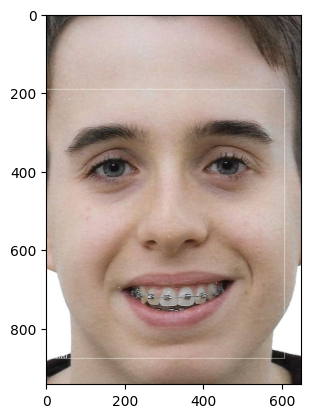

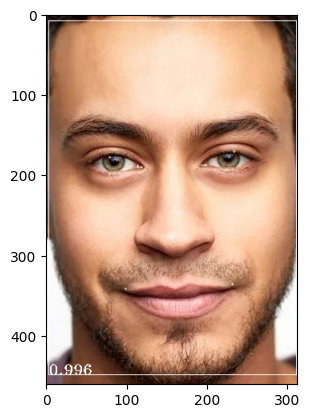

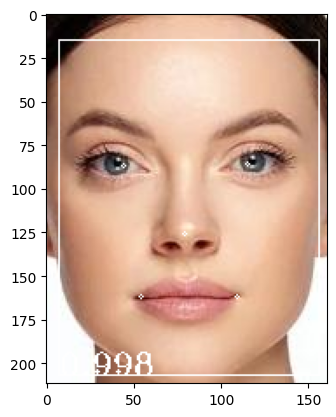

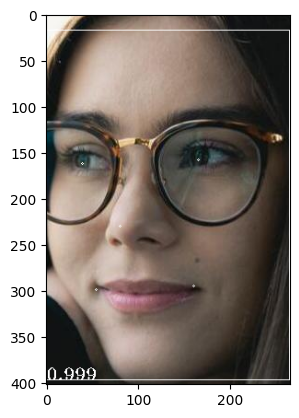

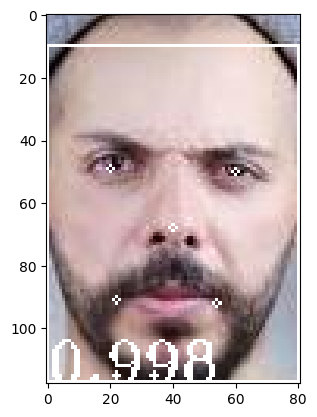

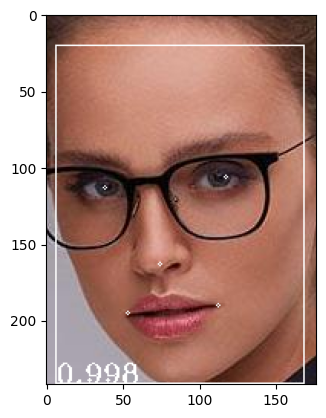

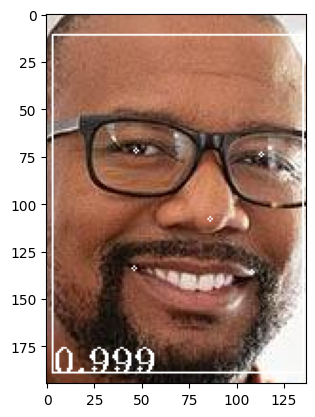

In [12]:
segments = face_segmentation.process_images()

In [22]:
# Inizializza e estrai i colori dominanti dai segmenti facciali
color_extractor = ColorExtractor(project_dir)

In [19]:
dominant_colors = color_extractor.extract_dominant_colors(segments)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8


Filename: result_0_0.jpg, Label: face


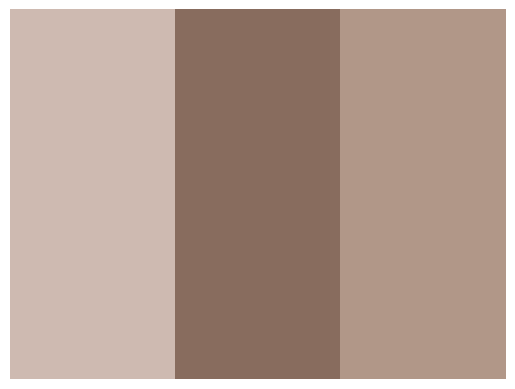


Filename: result_0_0.jpg, Label: rb


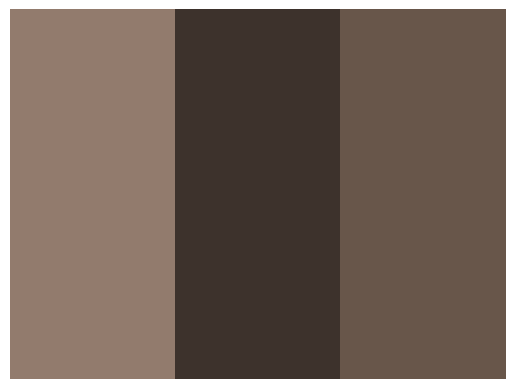


Filename: result_0_0.jpg, Label: lb


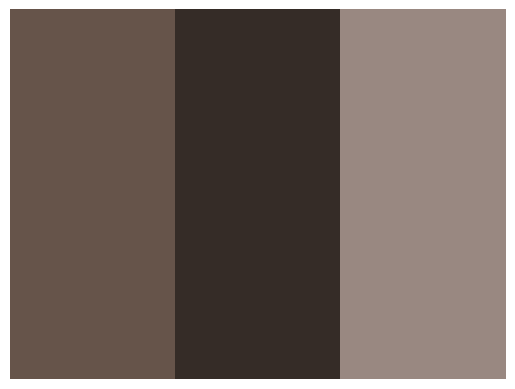


Filename: result_0_0.jpg, Label: re


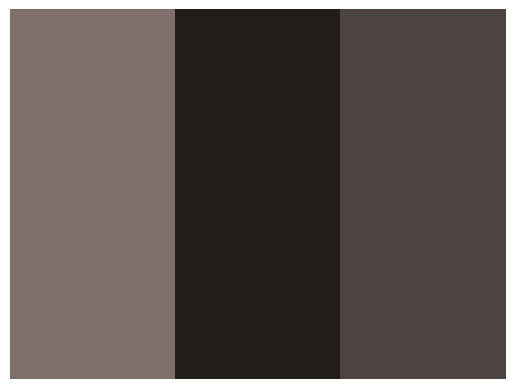


Filename: result_0_0.jpg, Label: le


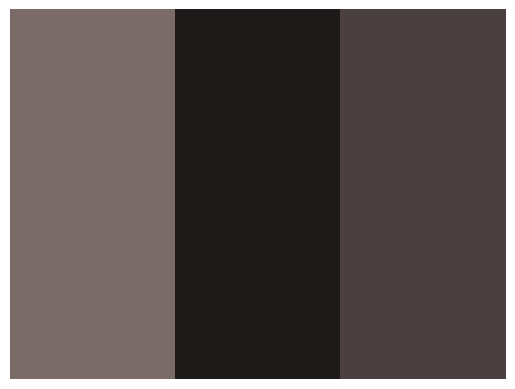


Filename: result_0_0.jpg, Label: nose


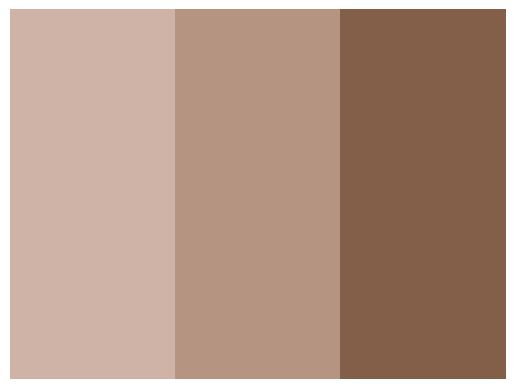


Filename: result_0_0.jpg, Label: ulip


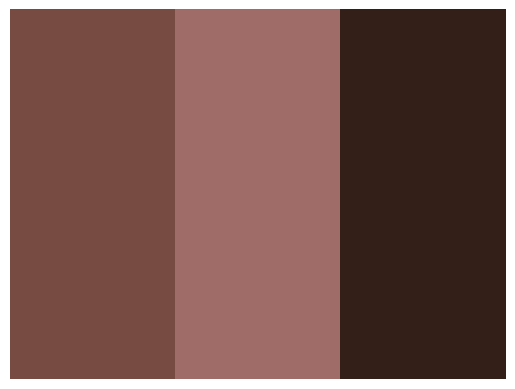


Filename: result_0_0.jpg, Label: llip


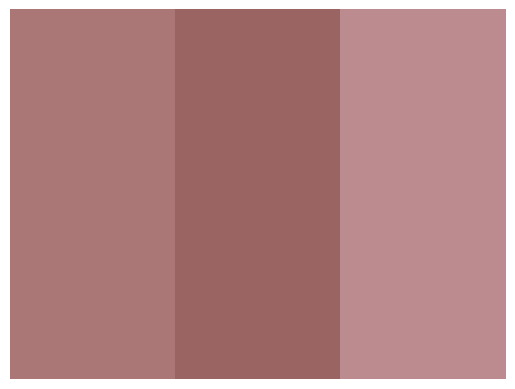


Filename: result_0_0.jpg, Label: hair


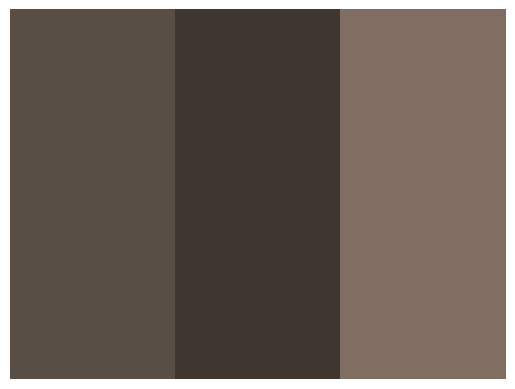


Filename: result_1_0.jpg, Label: face


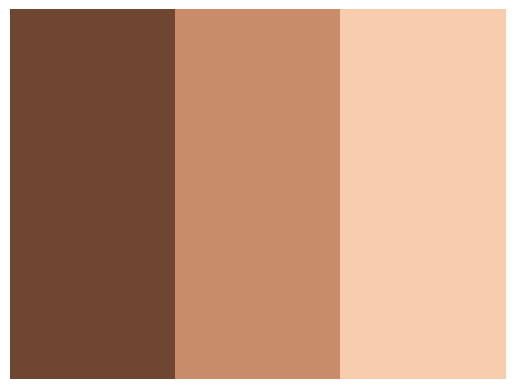


Filename: result_1_0.jpg, Label: rb


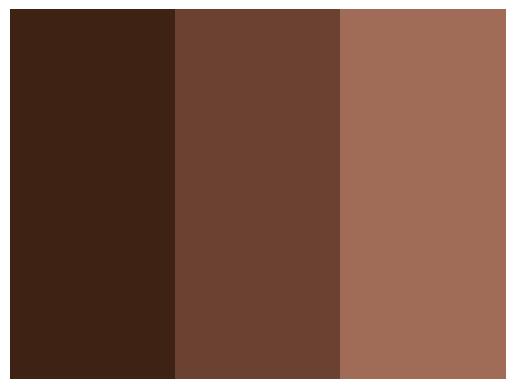


Filename: result_1_0.jpg, Label: lb


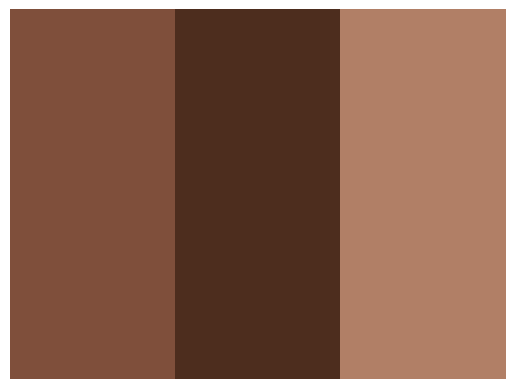


Filename: result_1_0.jpg, Label: re


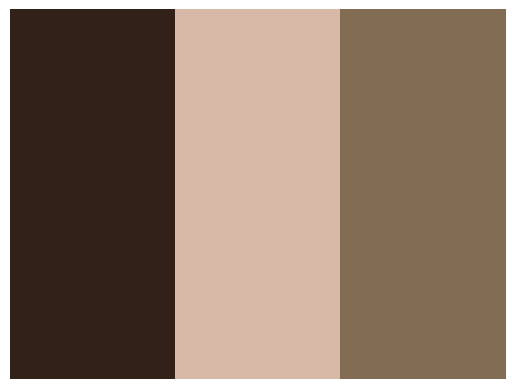


Filename: result_1_0.jpg, Label: le


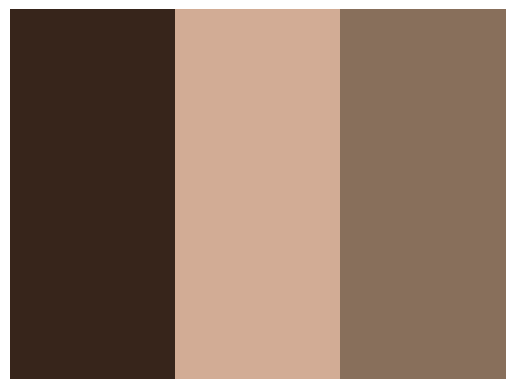


Filename: result_1_0.jpg, Label: nose


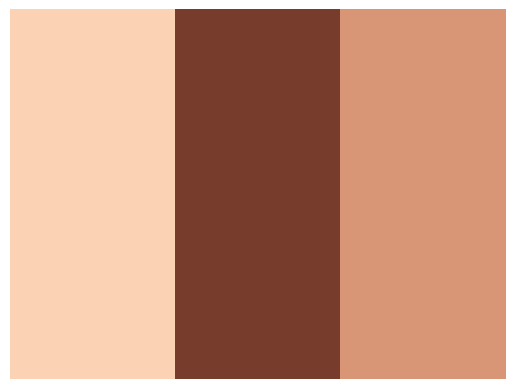


Filename: result_1_0.jpg, Label: ulip


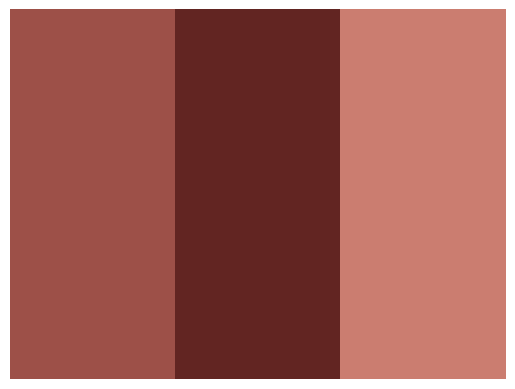


Filename: result_1_0.jpg, Label: llip


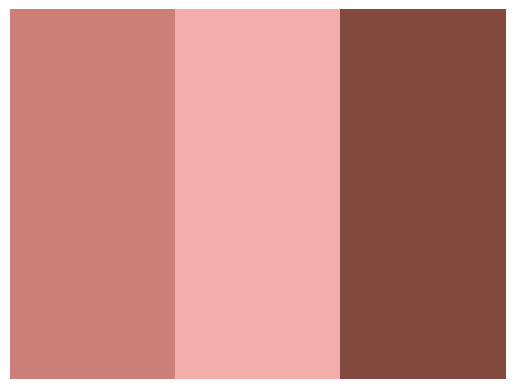


Filename: result_1_0.jpg, Label: hair


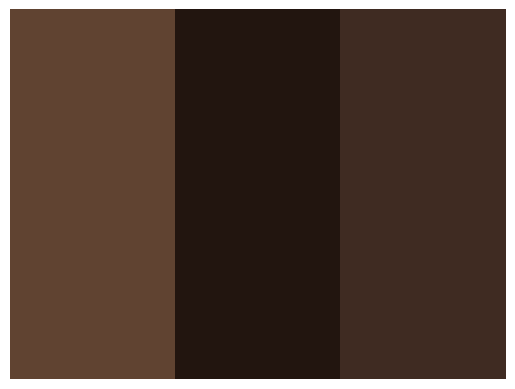


Filename: result_2_0.jpg, Label: face


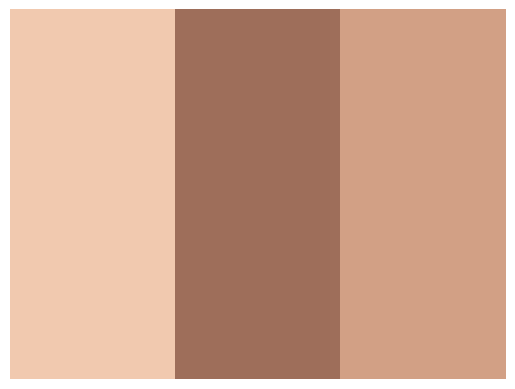


Filename: result_2_0.jpg, Label: rb


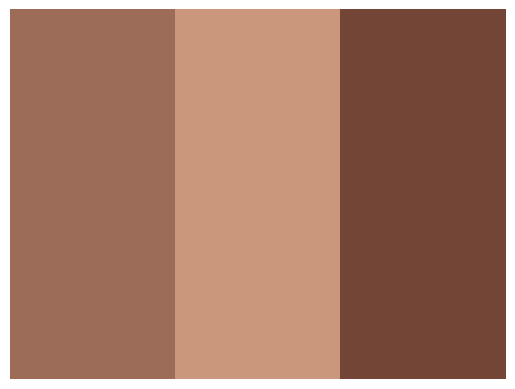


Filename: result_2_0.jpg, Label: lb


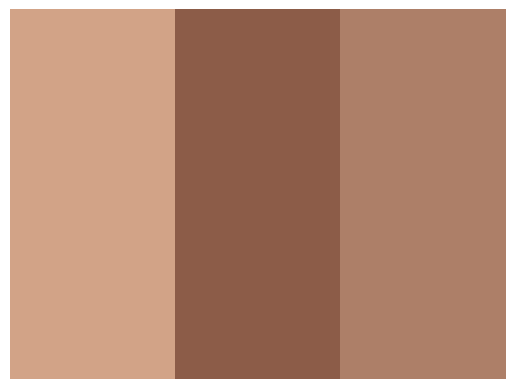


Filename: result_2_0.jpg, Label: re


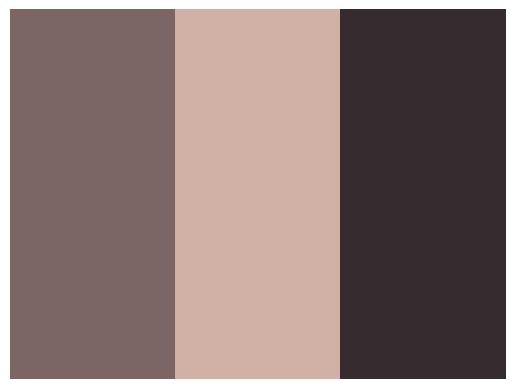


Filename: result_2_0.jpg, Label: le


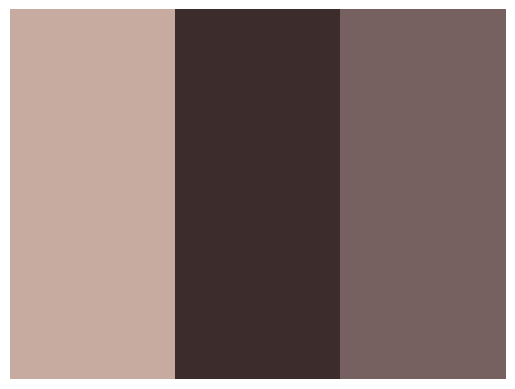


Filename: result_2_0.jpg, Label: nose


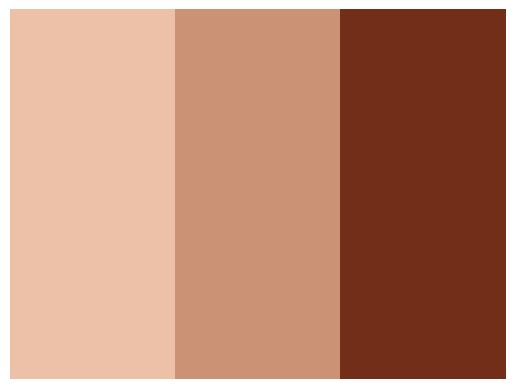


Filename: result_2_0.jpg, Label: ulip


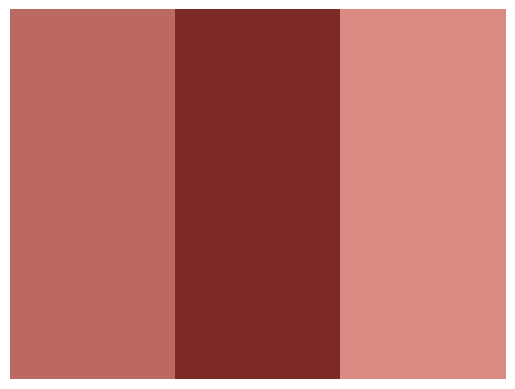


Filename: result_2_0.jpg, Label: llip


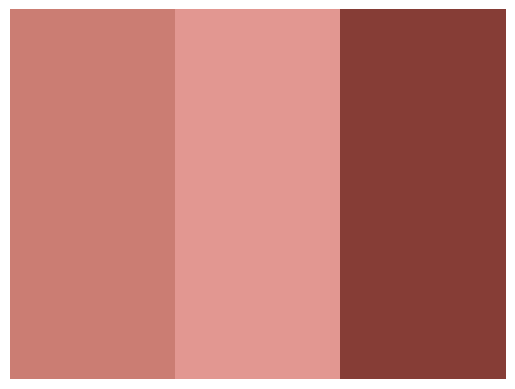


Filename: result_2_0.jpg, Label: hair


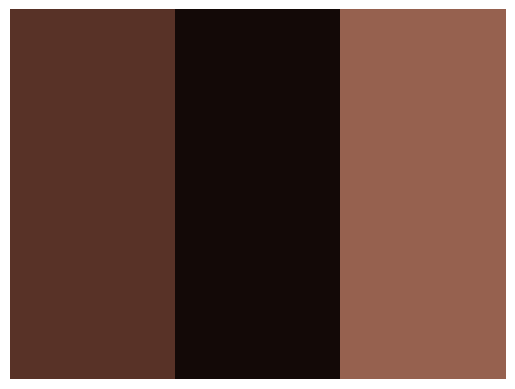


Filename: result_4_0.jpg, Label: face


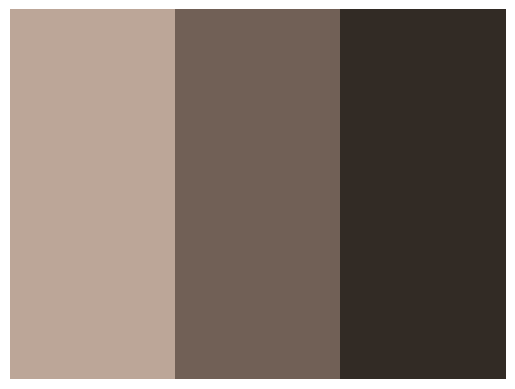


Filename: result_4_0.jpg, Label: rb


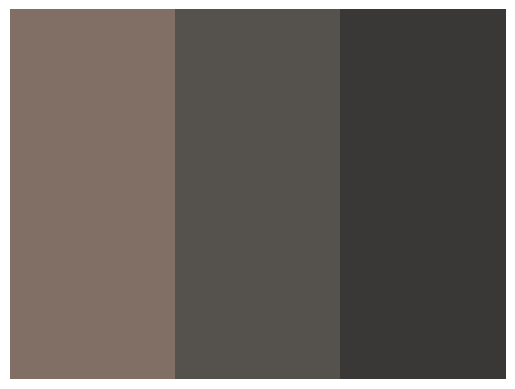


Filename: result_4_0.jpg, Label: lb


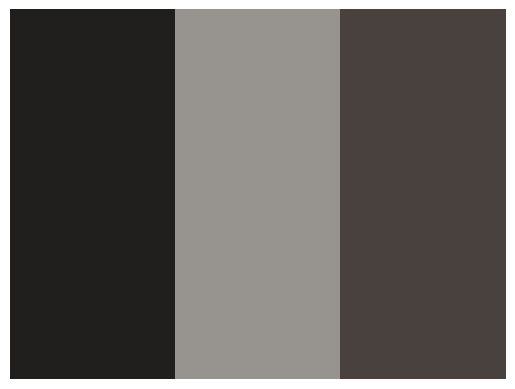


Filename: result_4_0.jpg, Label: re


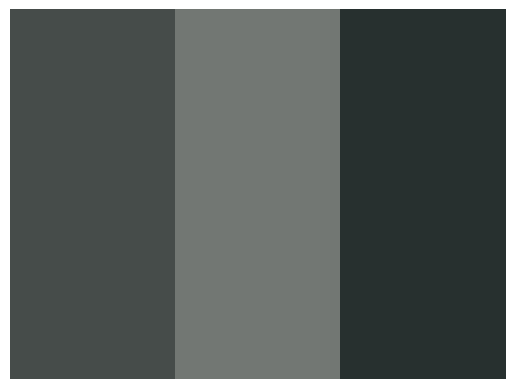


Filename: result_4_0.jpg, Label: le


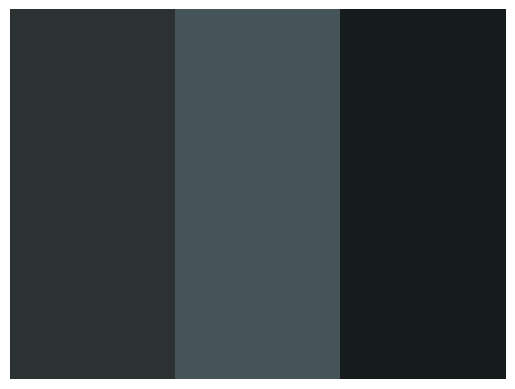


Filename: result_4_0.jpg, Label: nose


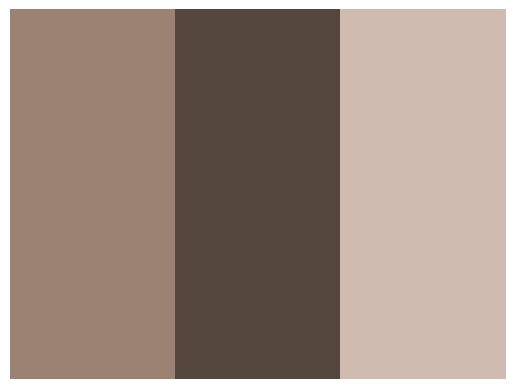


Filename: result_4_0.jpg, Label: ulip


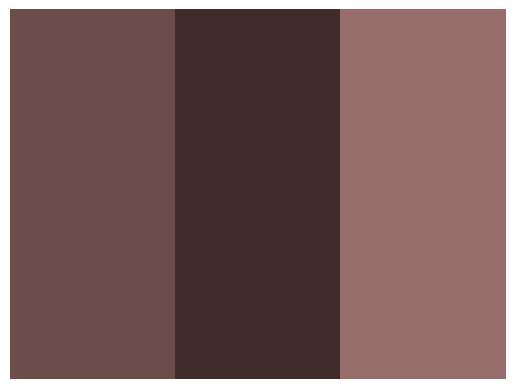


Filename: result_4_0.jpg, Label: llip


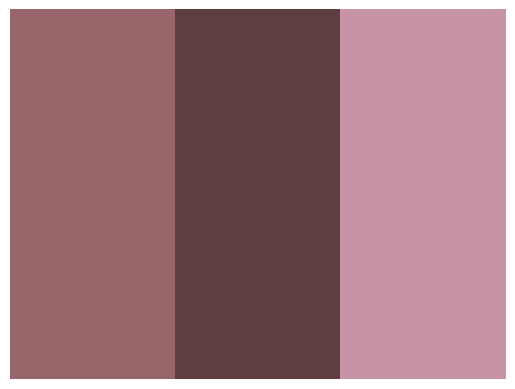


Filename: result_4_0.jpg, Label: hair


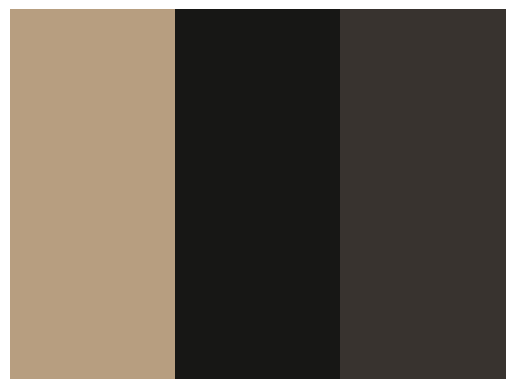


Filename: result_3_0.jpg, Label: face


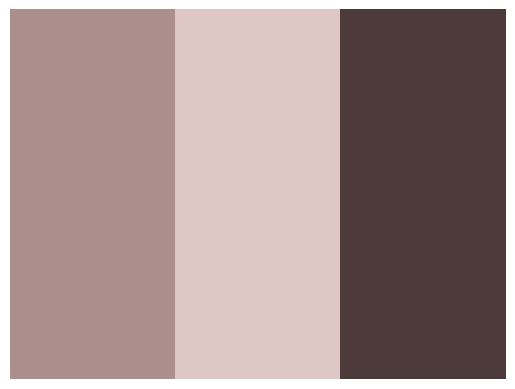


Filename: result_3_0.jpg, Label: rb


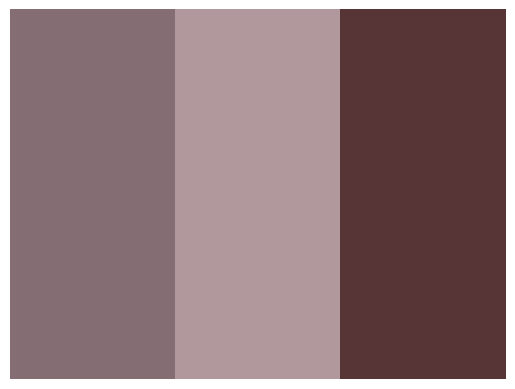


Filename: result_3_0.jpg, Label: lb


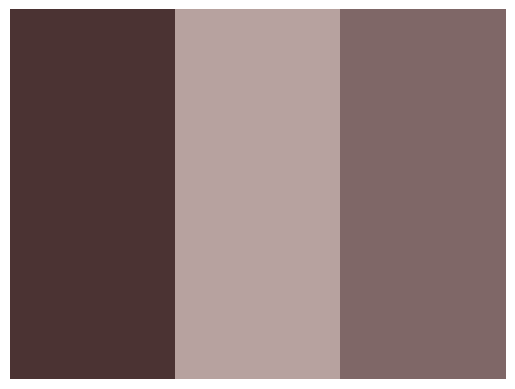


Filename: result_3_0.jpg, Label: re


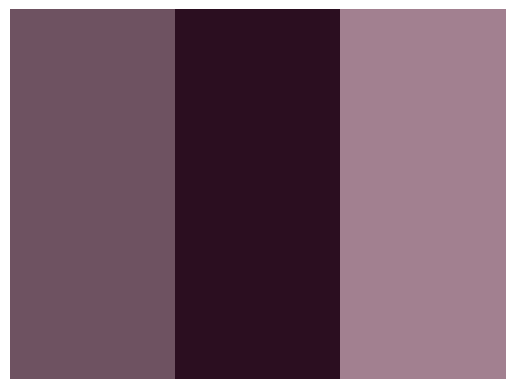


Filename: result_3_0.jpg, Label: le


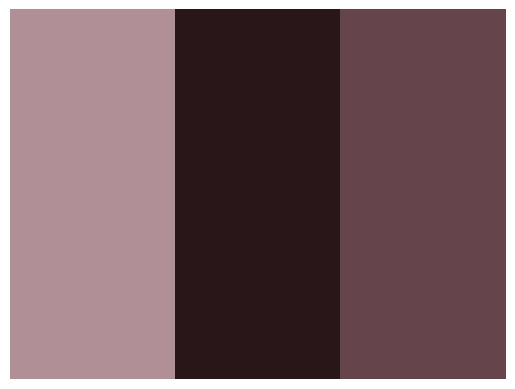


Filename: result_3_0.jpg, Label: nose


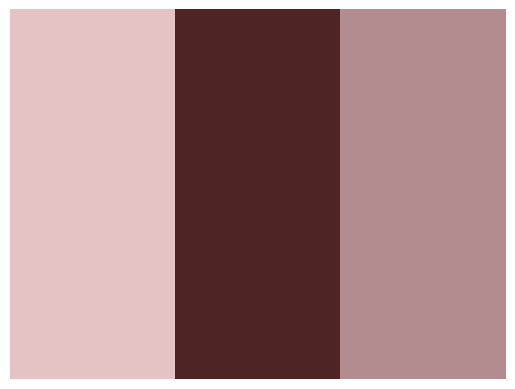


Filename: result_3_0.jpg, Label: ulip


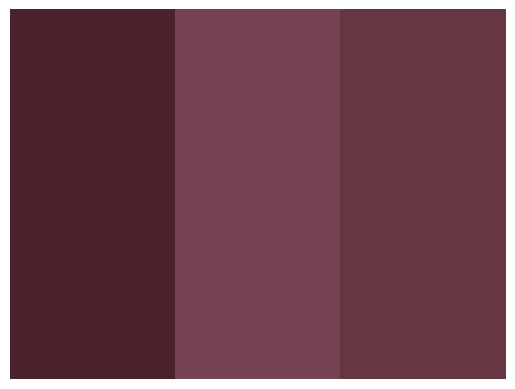


Filename: result_3_0.jpg, Label: llip


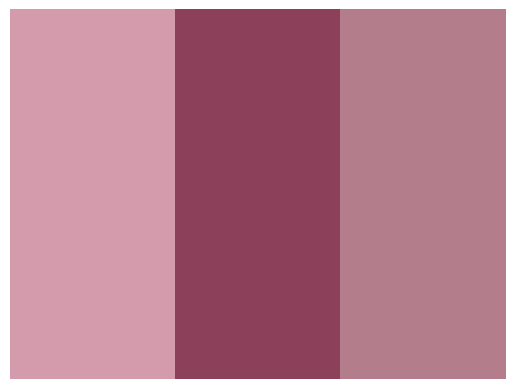


Filename: result_3_0.jpg, Label: hair


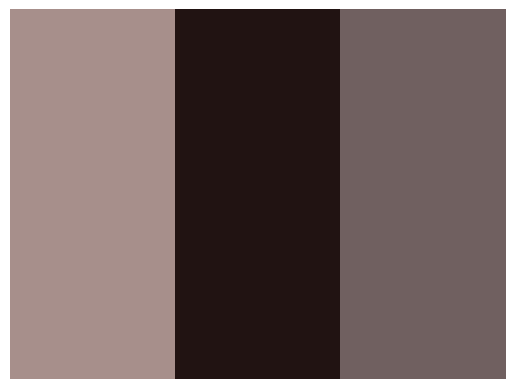


Filename: result_5_0.jpg, Label: face


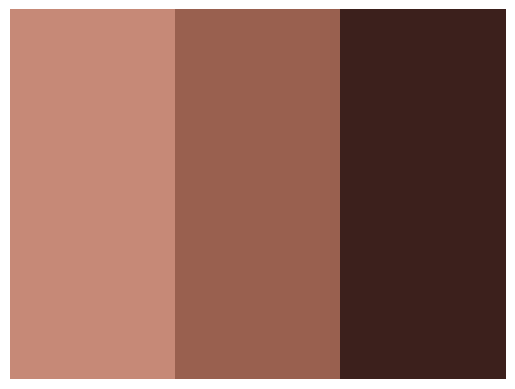


Filename: result_5_0.jpg, Label: rb


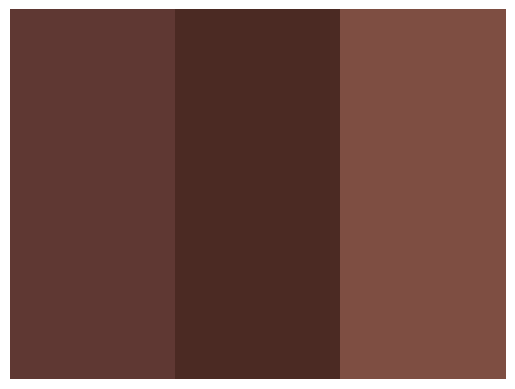


Filename: result_5_0.jpg, Label: lb


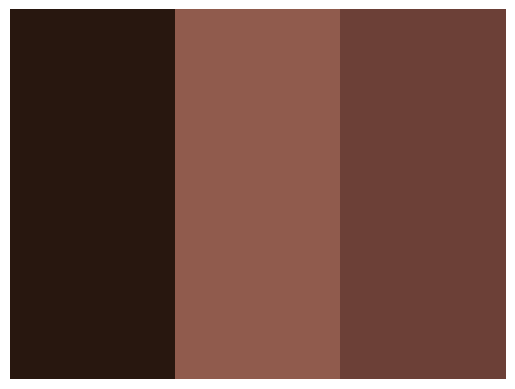


Filename: result_5_0.jpg, Label: re


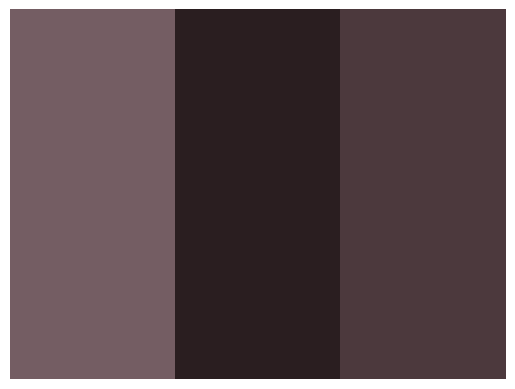


Filename: result_5_0.jpg, Label: le


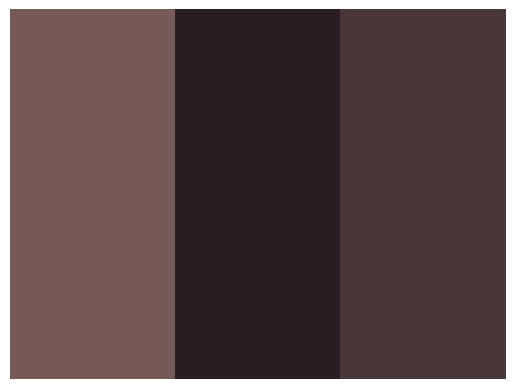


Filename: result_5_0.jpg, Label: nose


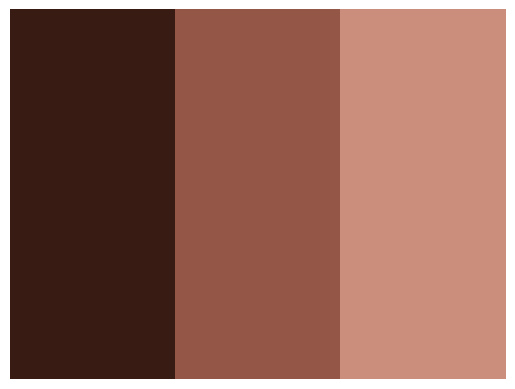


Filename: result_5_0.jpg, Label: ulip


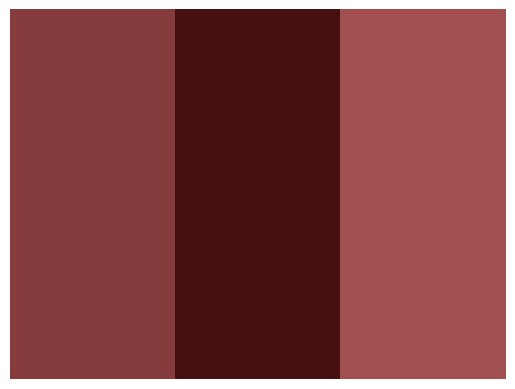


Filename: result_5_0.jpg, Label: llip


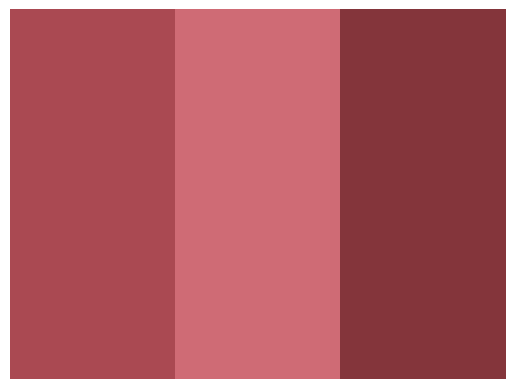


Filename: result_5_0.jpg, Label: hair


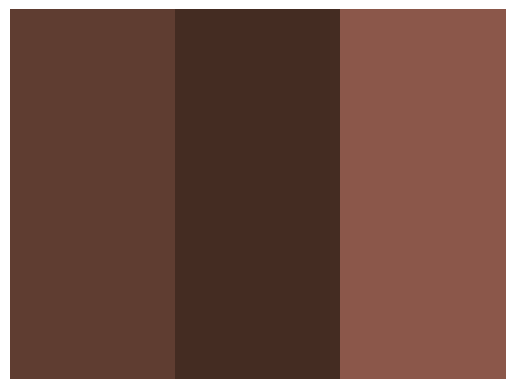


Filename: result_6_0.jpg, Label: face


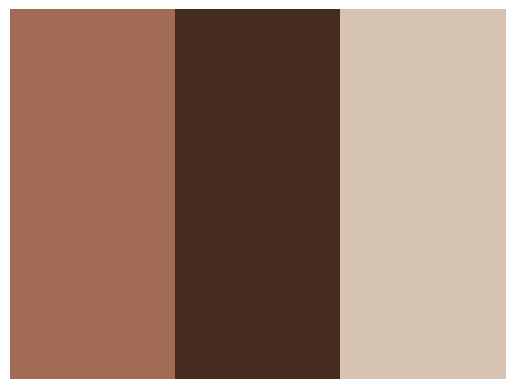


Filename: result_6_0.jpg, Label: rb


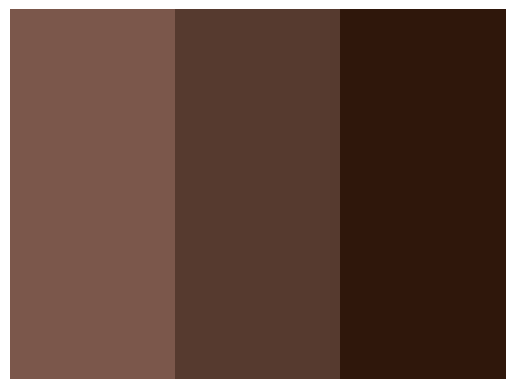


Filename: result_6_0.jpg, Label: lb


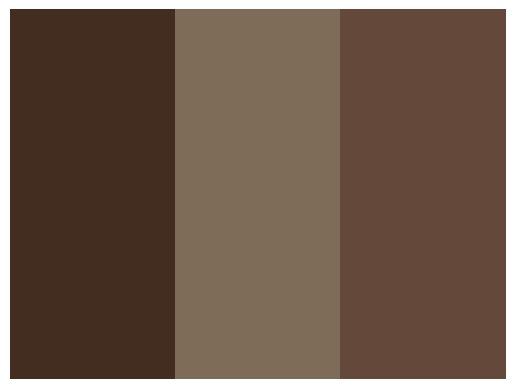


Filename: result_6_0.jpg, Label: re


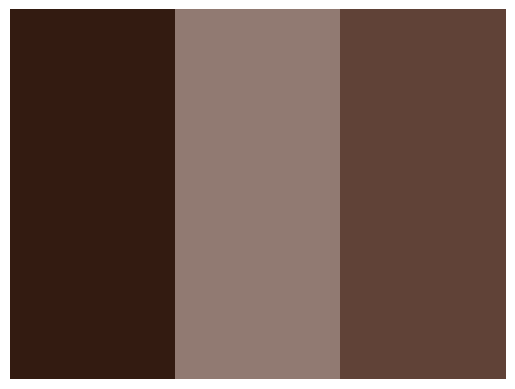


Filename: result_6_0.jpg, Label: le


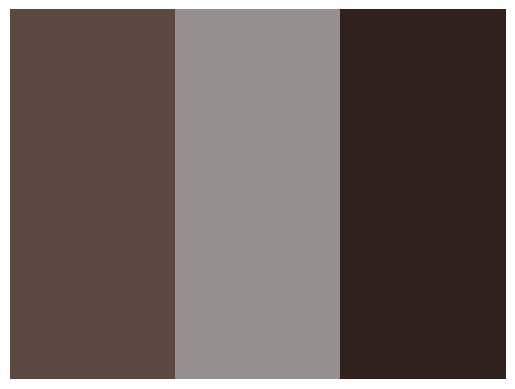


Filename: result_6_0.jpg, Label: nose


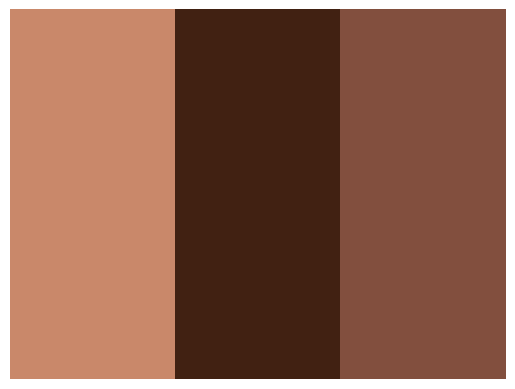


Filename: result_6_0.jpg, Label: ulip


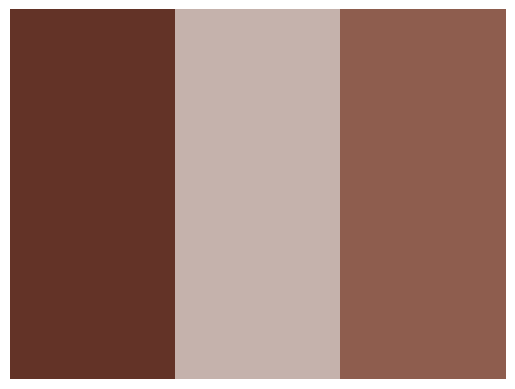


Filename: result_6_0.jpg, Label: llip


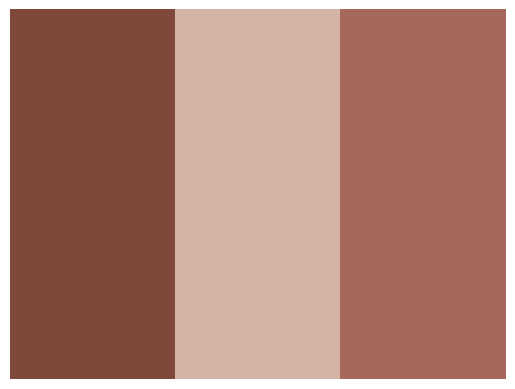


Filename: result_6_0.jpg, Label: hair


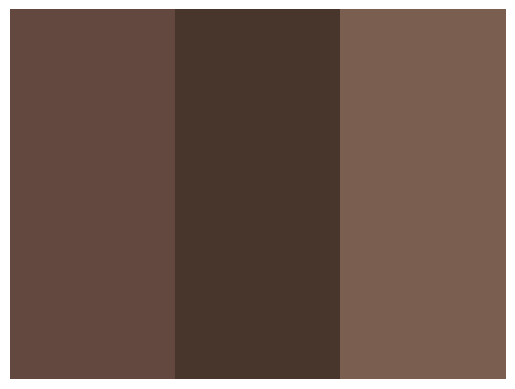

In [23]:
color_extractor.show_colors(dominant_colors)

In [24]:
# Utilizzo della funzione per salvare i dati in un file CSV
color_extractor.save_dominant_colors_to_csv(dominant_colors)

{'result_0_0.jpg': {'face': array([[206, 186, 177],
       [136, 108,  94],
       [177, 151, 136]], dtype=uint8), 'rb': array([[146, 123, 109],
       [ 61,  50,  44],
       [104,  86,  74]], dtype=uint8), 'lb': array([[102,  84,  74],
       [ 53,  44,  39],
       [153, 136, 129]], dtype=uint8), 're': array([[128, 110, 106],
       [ 33,  29,  28],
       [ 76,  68,  66]], dtype=uint8), 'le': array([[122, 107, 104],
       [ 30,  26,  25],
       [ 74,  64,  63]], dtype=uint8), 'nose': array([[207, 179, 167],
       [181, 148, 129],
       [131,  95,  73]], dtype=uint8), 'ulip': array([[119,  75,  66],
       [159, 108, 104],
       [ 51,  31,  24]], dtype=uint8), 'llip': array([[170, 119, 118],
       [154, 100,  98],
       [188, 139, 143]], dtype=uint8), 'hair': array([[ 88,  78,  69],
       [ 63,  54,  47],
       [128, 110,  98]], dtype=uint8)}, 'result_1_0.jpg': {'face': array([[111,  70,  50],
       [200, 140, 106],
       [248, 205, 173]], dtype=uint8), 'rb': array([[ 62,

In [25]:
# Inizializza e estrai i colori dominanti dai segmenti facciali
color_clusterer = ColorClusterer(project_dir)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



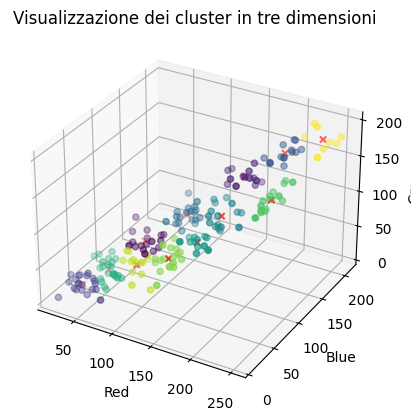

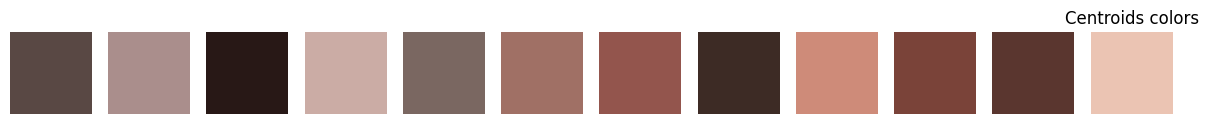

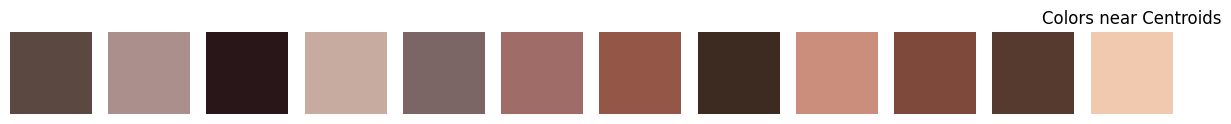

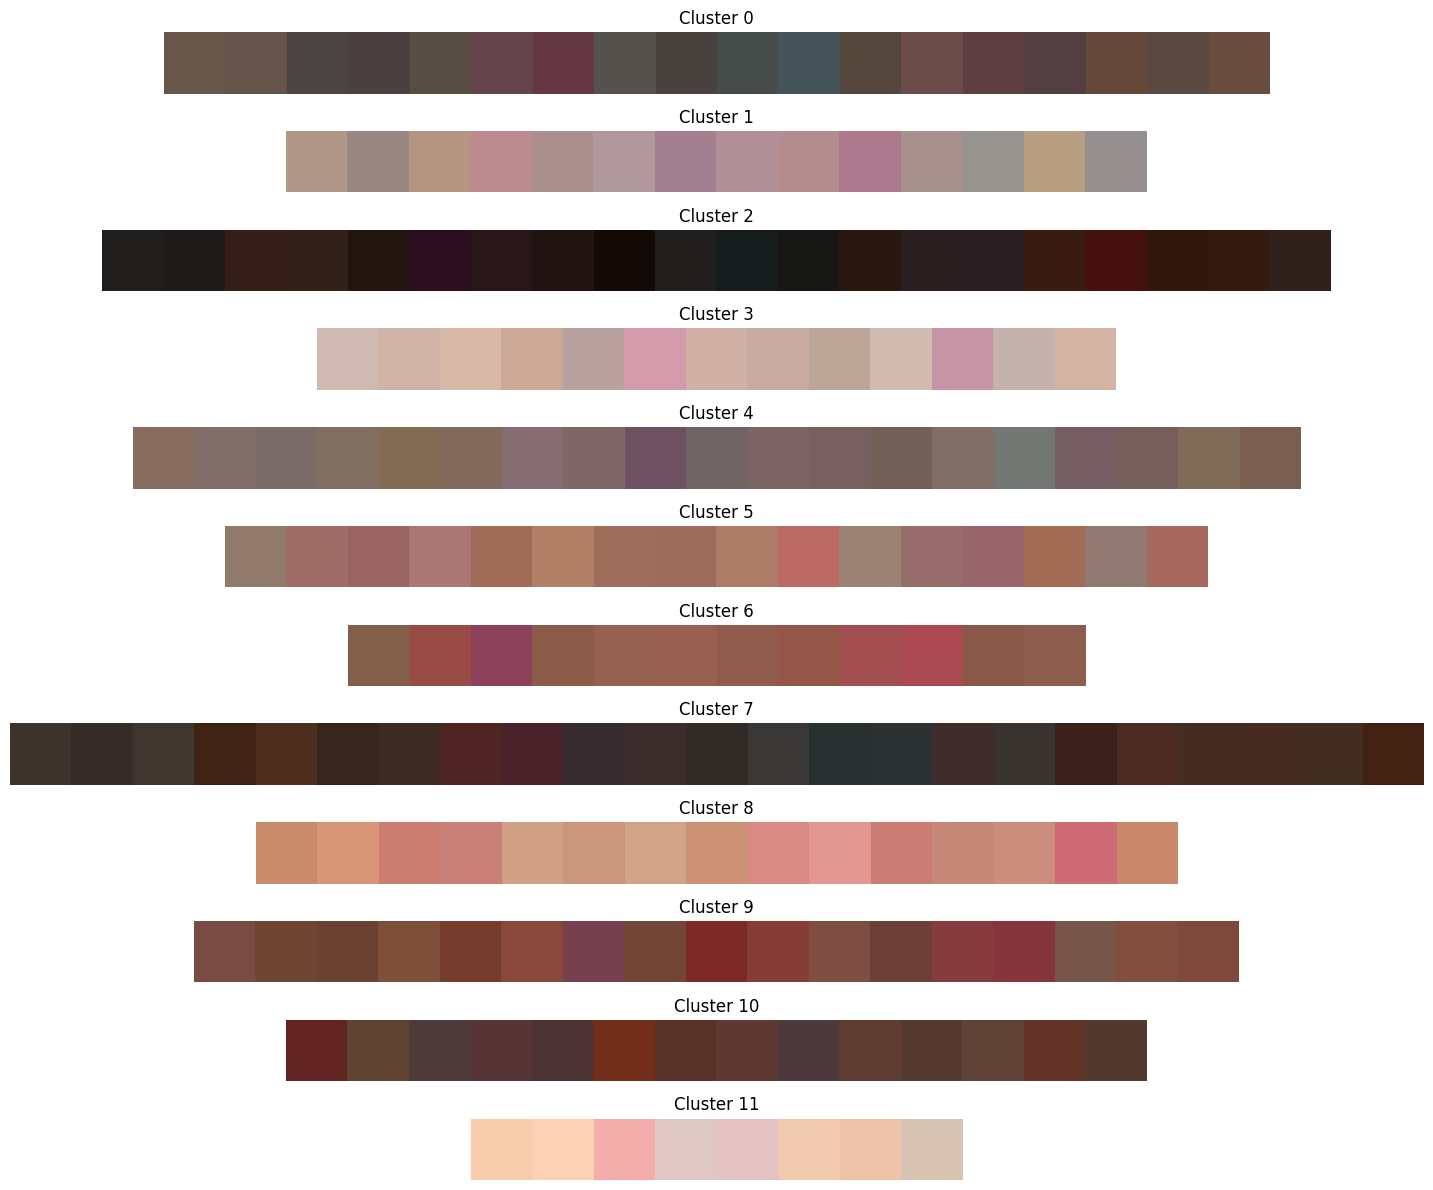

TypeError: Image data of dtype <U78 cannot be converted to float

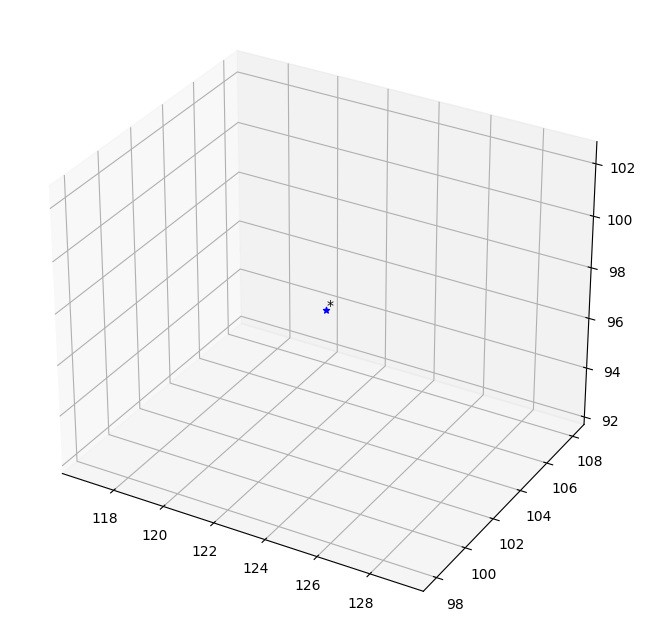

In [ ]:
color_clusterer.cluster(dominant_colors)

### Parte sotto da non considerare

In [ ]:
# Percorso del modello
model_path = os.path.join(project_dir, 'yolov8l-face.pt')

# Assicurati che il percorso del modello sia corretto
assert os.path.exists(model_path), f"Il percorso del modello non è valido"
# Run inference on an image with YOLOv8
model = YOLO(model_path)
results = model(os.path.join(project_dir, 'Faces.jpg'))

AssertionError: Il percorso del modello non è valido

In [ ]:
for i, result in enumerate(results):
    boxes = result.boxes.data  # Boxes object for bounding box outputs

    result.save(filename='result.jpg')
    img = mpimg.imread('result.jpg')
    plt.imshow(img)
    # Itera attraverso tutte le bounding box individuate
    for j, box in enumerate(boxes):
        # Ottieni le coordinate della bounding box
        x_min, y_min, x_max, y_max, conf, cls = box.tolist()[:6]

        # Ritaglia l'area corrispondente dall'immagine originale
        img = Image.open(os.path.join(project_dir, 'Faces.jpg'))
        cropped_img = img.crop((x_min, y_min, x_max, y_max))

        # Salva l'immagine ritagliata
        directory = "faces"
        # Controllo se la cartella esiste, altrimenti la creo
        if not os.path.exists(directory):
            os.makedirs(directory)
        #shutil.rmtree(directory)
        cropped_img.save(os.path.join(directory,f'result_{i}_{"0" * (len(str(len(boxes))) - len(str(j)))}{j}.jpg'))